# 大类资产相关系数预测模型

本项目使用LSTM模型预测大类资产间的相关系数，并与基于历史值的预测结果进行对比。

## 1. 环境准备

导入必要的库并设置环境：
- 数据处理：pandas, numpy
- 机器学习：sklearn, keras
- 可视化：matplotlib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.optimizers import Adam

import random
import tensorflow as tf

In [2]:
# 设置中文字体显示
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
matplotlib.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)  # 在所有初始化前调用

## 2. 数据预处理

### 2.1 数据加载与合并
- 加载指数行情数据
- 加载利率和汇率数据
- 合并数据集

### 2.2 数据清洗
- 处理缺失值
- 数据类型转换与尺度调整
- 导出处理后的数据

In [4]:
# 加载并预处理指数行情序列数据集
raw_data = pd.read_csv('Data/指数行情_cov.csv')
raw_data['日期'] = pd.to_datetime(raw_data['日期'], format='%Y/%m/%d')
for column in raw_data.columns:
    if (raw_data[column].dtype == 'object'):
        raw_data[column] = raw_data[column].astype('float64')

## 3. 特征工程

### 3.1 计算金融指标
- 对数收益率计算
- 滚动波动率计算（20日窗口）
- 滚动相关系数计算（20日窗口）

### 3.2 数据准备
- 构建时间序列特征（20天回溯窗口）
- 准备目标变量
  - 未来20日相关系数
- 准备历史法对照组
  - 过去相关系数

In [5]:
# 计算对数收益率
log_returns = pd.DataFrame()
for column in raw_data.columns[1:]:
    log_returns[f'{column}_收益率'] = np.log(raw_data[column] / raw_data[column].shift(1))
log_returns['日期'] = raw_data['日期']
log_returns.set_index('日期', inplace=True)

In [6]:
log_returns.head()

,上证指数_收益率,标普500_收益率,中债国债总指数_收益率,恒生指数_收益率,南华黑色_收益率,南华黄金_收益率
日期,,,,,,
2018-06-29,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-02,-0.025561,0.003063,0.000739,0.000000,-0.025595,0.002569
2018-07-03,0.004074,-0.004960,0.000114,-0.014245,0.001261,-0.000736
2018-07-04,-0.010011,0.000000,-0.000227,-0.010703,0.002456,0.002761
2018-07-05,-0.009194,0.008584,0.000738,-0.002112,-0.006913,0.000367


In [7]:
# 计算滚动波动率
rolling_volatility = pd.DataFrame()
for column in log_returns.columns:
    rolling_volatility[f'{column}_波动率'] = log_returns[column].rolling(window=20).std()

In [8]:
# 计算滚动相关系数
asset_cols = [col for col in log_returns.columns]
rolling_corr = pd.DataFrame(index=log_returns.index)

# 计算每对资产之间的滚动相关系数
for i in range(len(asset_cols)):
    for j in range(i+1, len(asset_cols)):
        col1 = asset_cols[i]
        col2 = asset_cols[j]
        corr_name = f"{col1.split('_')[0]}_{col2.split('_')[0]}_corr"
        rolling_corr[corr_name] = log_returns[col1].rolling(window=20).corr(log_returns[col2])

# 显示结果的前几行和基本信息
print("\nShape:", rolling_corr.shape)
print("\nColumns:", list(rolling_corr.columns))


Shape: (1832, 15)

Columns: ['上证指数_标普500_corr', '上证指数_中债国债总指数_corr', '上证指数_恒生指数_corr', '上证指数_南华黑色_corr', '上证指数_南华黄金_corr', '标普500_中债国债总指数_corr', '标普500_恒生指数_corr', '标普500_南华黑色_corr', '标普500_南华黄金_corr', '中债国债总指数_恒生指数_corr', '中债国债总指数_南华黑色_corr', '中债国债总指数_南华黄金_corr', '恒生指数_南华黑色_corr', '恒生指数_南华黄金_corr', '南华黑色_南华黄金_corr']


In [9]:
rolling_corr = rolling_corr / 10  # scaling

In [ ]:
rolling_corr

,上证指数_标普500_corr,上证指数_中债国债总指数_corr,上证指数_恒生指数_corr,上证指数_南华黑色_corr,上证指数_南华黄金_corr,标普500_中债国债总指数_corr,标普500_恒生指数_corr,标普500_南华黑色_corr,标普500_南华黄金_corr,中债国债总指数_恒生指数_corr,中债国债总指数_南华黑色_corr,中债国债总指数_南华黄金_corr,恒生指数_南华黑色_corr,恒生指数_南华黄金_corr,南华黑色_南华黄金_corr
日期,,,,,,,,,,,,,,,
2018-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-01,0.009221,-0.086754,0.094959,0.043567,0.045562,0.014331,0.008817,-0.013976,-0.004389,-0.087867,-0.048331,-0.018508,0.055713,0.027855,-0.014648
2025-05-02,0.008518,-0.036081,0.035835,-0.015818,0.037081,0.037584,0.009469,-0.019625,-0.007909,-0.043543,-0.014288,0.027023,0.032979,-0.028821,-0.041211
2025-05-05,0.026423,-0.001568,0.032066,0.016615,0.048346,0.032923,0.015072,-0.033817,-0.008091,-0.039835,-0.060425,0.031260,0.048262,-0.027790,-0.048808


In [11]:
# 合并对数收益率和滚动波动率
r_v = pd.merge(log_returns, rolling_volatility, left_index=True, right_index=True)
r_v_corr = pd.merge(r_v, rolling_corr, left_index=True, right_index=True)

In [12]:
r_v_corr.dropna(inplace=True)

In [13]:
r_v_corr.describe()

,上证指数_收益率,标普500_收益率,中债国债总指数_收益率,恒生指数_收益率,南华黑色_收益率,南华黄金_收益率,上证指数_收益率_波动率,标普500_收益率_波动率,中债国债总指数_收益率_波动率,恒生指数_收益率_波动率,...,标普500_中债国债总指数_corr,标普500_恒生指数_corr,标普500_南华黑色_corr,标普500_南华黄金_corr,中债国债总指数_恒生指数_corr,中债国债总指数_南华黑色_corr,中债国债总指数_南华黄金_corr,恒生指数_南华黑色_corr,恒生指数_南华黄金_corr,南华黑色_南华黄金_corr
count,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,...,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000
mean,0.000082,0.000378,0.000187,-0.000131,0.000472,0.000535,0.009802,0.010348,0.001040,0.013609,...,-0.001962,0.016882,0.002264,0.002459,-0.019135,-0.016241,0.010697,0.022000,0.000423,0.002952
std,0.010647,0.012555,0.001176,0.014665,0.015550,0.008082,0.004313,0.007181,0.000504,0.005546,...,0.022370,0.023007,0.025071,0.022107,0.026584,0.024557,0.024496,0.023765,0.030256,0.028527
min,-0.080391,-0.127652,-0.008136,-0.141833,-0.079641,-0.058369,0.003637,0.003109,0.000183,0.005207,...,-0.059840,-0.052791,-0.085919,-0.062865,-0.087867,-0.092789,-0.055534,-0.065792,-0.077069,-0.083726
25%,-0.004583,-0.004158,-0.000288,-0.007443,-0.007546,-0.002787,0.007048,0.006258,0.000682,0.010310,...,-0.017712,0.001114,-0.014004,-0.012583,-0.038203,-0.033953,-0.007488,0.007402,-0.022027,-0.016186
50%,0.000000,0.000165,0.000158,0.000000,0.000000,0.000000,0.008479,0.008602,0.000919,0.012418,...,-0.001231,0.016783,0.001293,0.003892,-0.018753,-0.017896,0.011014,0.022556,0.000464,0.004243
75%,0.005047,0.006281,0.000743,0.007102,0.009370,0.004340,0.010968,0.012412,0.001246,0.014858,...,0.013713,0.033631,0.021082,0.017972,-0.000323,0.000963,0.029077,0.038935,0.022087,0.023705
max,0.077551,0.090895,0.010514,0.086928,0.074838,0.053986,0.030427,0.061669,0.002947,0.035261,...,0.058352,0.075630,0.066204,0.060511,0.057156,0.065038,0.090226,0.081309,0.078331,0.074043


In [14]:
mean_returns = r_v.iloc[:1417, :17].mean().values
mean_returns

array([ 5.05508032e-05,  3.26251543e-04,  1.60831645e-04, -3.46289871e-04,
        7.79294082e-04,  3.23431764e-04,  9.83371983e-03,  1.07823409e-02,
        9.88508420e-04,  1.31413390e-02,  1.51553384e-02,  7.23664629e-03])

In [15]:
r_v_corr.shape

(1812, 27)

其他输入特征

In [16]:
raw_data_2 = pd.read_excel('Data/利率和汇率数据_V1.xlsx')

raw_data_2.replace(0, np.nan, inplace=True)

raw_data_2['日期'] = pd.to_datetime(raw_data_2['日期'], format='%Y%m%d')

raw_data_2.iloc[:, 1:3] = raw_data_2.iloc[:, 1:3].apply(lambda x: x / 100)

raw_data_2['CNYUSD'] = 0.1 / raw_data_2['CNYUSD']  # scaling

In [17]:
raw_data_2

,日期,R001,R007,CNYUSD
0,1971-06-01,NaN,NaN,NaN
1,1971-06-02,NaN,NaN,NaN
2,1971-06-03,NaN,NaN,NaN
3,1971-06-04,NaN,NaN,NaN
4,1971-06-07,NaN,NaN,NaN
...,...,...,...,...
14080,2025-05-12,0.014565,0.015499,0.013876
14081,2025-05-13,0.014343,0.015337,0.013891
14082,2025-05-14,0.014412,0.015440,0.013897
14083,2025-05-15,0.014477,0.015456,0.013896


In [18]:
X = pd.merge(r_v_corr, raw_data_2, on='日期', how='left')  # 只添加利率汇率数据
X.ffill(inplace=True)

In [19]:
X.head(10)

,日期,上证指数_收益率,标普500_收益率,中债国债总指数_收益率,恒生指数_收益率,南华黑色_收益率,南华黄金_收益率,上证指数_收益率_波动率,标普500_收益率_波动率,中债国债总指数_收益率_波动率,...,标普500_南华黄金_corr,中债国债总指数_恒生指数_corr,中债国债总指数_南华黑色_corr,中债国债总指数_南华黄金_corr,恒生指数_南华黑色_corr,恒生指数_南华黄金_corr,南华黑色_南华黄金_corr,R001,R007,CNYUSD
0,2018-07-27,-0.003002,-0.006584,0.001360,0.000804,0.028252,-0.002200,0.013021,0.005276,0.000874,...,-0.023405,-0.042157,-0.012199,-0.005356,0.018018,-0.011337,-0.008856,0.022917,0.028034,0.014718
1,2018-07-30,-0.001581,-0.005771,0.000793,-0.002473,0.004132,0.000180,0.011516,0.005530,0.000875,...,-0.024351,-0.043096,-0.003571,-0.007944,0.023434,-0.011779,0.003321,0.022059,0.027718,0.014678
2,2018-07-31,0.002559,0.004873,0.001810,-0.005238,0.002928,0.000368,0.011504,0.005372,0.000948,...,-0.025980,-0.049800,-0.004738,-0.006242,0.022473,-0.015191,0.002860,0.021073,0.027497,0.014670
3,2018-08-01,-0.018198,-0.001041,0.001016,-0.008512,-0.007412,-0.000737,0.012070,0.005396,0.000955,...,-0.024212,-0.059206,-0.010074,-0.004432,0.028486,-0.007560,0.004901,0.020471,0.026388,0.014643
4,2018-08-02,-0.020210,0.004914,0.000226,-0.022342,0.005108,-0.002584,0.012797,0.005213,0.000950,...,-0.028531,-0.047679,-0.007590,-0.004541,0.021512,0.003361,0.005937,0.019806,0.024149,0.014718
5,2018-08-03,-0.010014,0.004633,0.000959,-0.001381,0.020101,-0.002031,0.012969,0.005016,0.000916,...,-0.036784,-0.045498,-0.004644,-0.001237,0.021320,0.001072,0.002862,0.018611,0.023334,0.014637
6,2018-08-06,-0.012957,0.003532,0.000564,0.005162,0.023467,0.000181,0.011896,0.004742,0.000895,...,-0.038287,-0.039908,-0.000833,-0.001072,0.024506,0.002080,0.004796,0.018298,0.023472,0.014596
7,2018-08-07,0.027063,0.002820,-0.000113,0.015314,0.005190,-0.000551,0.013506,0.004727,0.000893,...,-0.036819,-0.042009,-0.002912,-0.005310,0.022105,0.002247,0.000976,0.016295,0.023226,0.014613
8,2018-08-08,-0.012782,-0.000262,-0.001692,0.003896,-0.004150,-0.002226,0.013219,0.004328,0.001010,...,-0.027694,-0.041903,0.008578,-0.000300,0.018900,0.010232,0.005042,0.014489,0.023404,0.014639
9,2018-08-09,0.018168,-0.001443,-0.002656,0.008713,0.004051,0.000190,0.012959,0.004021,0.001211,...,-0.021328,-0.046407,0.009654,-0.003814,0.014594,0.015178,0.011468,0.016658,0.022572,0.014638


In [20]:
X.describe()

,日期,上证指数_收益率,标普500_收益率,中债国债总指数_收益率,恒生指数_收益率,南华黑色_收益率,南华黄金_收益率,上证指数_收益率_波动率,标普500_收益率_波动率,中债国债总指数_收益率_波动率,...,标普500_南华黄金_corr,中债国债总指数_恒生指数_corr,中债国债总指数_南华黑色_corr,中债国债总指数_南华黄金_corr,恒生指数_南华黑色_corr,恒生指数_南华黄金_corr,南华黑色_南华黄金_corr,R001,R007,CNYUSD
count,1812,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,...,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000,1812.000000
mean,2021-12-17 12:54:50.066225152,0.000082,0.000378,0.000187,-0.000131,0.000472,0.000535,0.009802,0.010348,0.001040,...,0.002459,-0.019135,-0.016241,0.010697,0.022000,0.000423,0.002952,0.018816,0.022523,0.014571
min,2018-07-27 00:00:00,-0.080391,-0.127652,-0.008136,-0.141833,-0.079641,-0.058369,0.003637,0.003109,0.000183,...,-0.062865,-0.087867,-0.092789,-0.055534,-0.065792,-0.077069,-0.083726,0.006779,0.012570,0.013783
25%,2020-04-08 18:00:00,-0.004583,-0.004158,-0.000288,-0.007443,-0.007546,-0.002787,0.007048,0.006258,0.000682,...,-0.012583,-0.038203,-0.033953,-0.007488,0.007402,-0.022027,-0.016186,0.015859,0.019256,0.014077
50%,2021-12-20 12:00:00,0.000000,0.000165,0.000158,0.000000,0.000000,0.000000,0.008479,0.008602,0.000919,...,0.003892,-0.018753,-0.017896,0.011014,0.022556,0.000464,0.004243,0.018548,0.022080,0.014437
75%,2023-08-29 06:00:00,0.005047,0.006281,0.000743,0.007102,0.009370,0.004340,0.010968,0.012412,0.001246,...,0.017972,-0.000323,0.000963,0.029077,0.038935,0.022087,0.023705,0.021749,0.025118,0.014908
max,2025-05-07 00:00:00,0.077551,0.090895,0.010514,0.086928,0.074838,0.053986,0.030427,0.061669,0.002947,...,0.060511,0.057156,0.065038,0.090226,0.081309,0.078331,0.074043,0.065883,0.059222,0.015869
std,NaN,0.010647,0.012555,0.001176,0.014665,0.015550,0.008082,0.004313,0.007181,0.000504,...,0.022107,0.026584,0.024557,0.024496,0.023765,0.030256,0.028527,0.004766,0.004489,0.000583


In [21]:
X.set_index('日期', inplace=True)

In [22]:
# LSTM模型输入数据准备
lookback_window = 20

X_features, y, y_hist = [], [], []
for i in range(lookback_window, len(r_v_corr) - 20):
    X_features.append(X.iloc[i - lookback_window:i, :].values)
    y.append(rolling_corr.iloc[i + 19, :].values)  # 相关系数预测的target为未来20日窗口的波动率
    y_hist.append(rolling_corr.iloc[i - 1, :].values)  # 历史法预测相关系数，取过去为60日窗口的波动率；时间尺度上进行调整

X_features = np.array(X_features)
y = np.array(y)
y_hist = np.array(y_hist)

In [23]:
y_hist

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 0.03800203, -0.06213506,  0.06363423, ...,  0.01801842,
        -0.01133676, -0.00885608],
       [ 0.04583684, -0.06314664,  0.07261893, ...,  0.02343403,
        -0.0117791 ,  0.00332062],
       ...,
       [-0.03634688, -0.01538938,  0.07253202, ...,  0.0310009 ,
        -0.01042737, -0.03186751],
       [-0.03645094, -0.01744064,  0.07164647, ...,  0.02605797,
        -0.00386898, -0.02405585],
       [-0.03909445, -0.02377308,  0.07025352, ...,  0.02096163,
        -0.00039834, -0.01956849]])

In [24]:
X_features.shape, y.shape, y_hist.shape

((1772, 20, 30), (1772, 15), (1772, 15))

## 4. 模型训练与评估

### 4.1 数据集划分
- 训练集：80%
- 测试集：20%
- 特征标准化

In [25]:
# 训练集和测试集划分
split_index = int(0.8 * len(X_features))
X_train, X_test = X_features[:split_index], X_features[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [26]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1417, 20, 30), (355, 20, 30), (1417, 15), (355, 15))

In [27]:
X_train[0, 0, :]

array([-0.00300218, -0.00658388,  0.00136047,  0.00080368,  0.02825175,
       -0.00220036,  0.01302051,  0.005276  ,  0.00087354,  0.00816901,
        0.01074635,  0.00324344,  0.03800203, -0.06213506,  0.06363423,
        0.05216142, -0.02212534, -0.03906232,  0.05806147, -0.01656727,
       -0.02340531, -0.04215695, -0.01219851, -0.00535607,  0.01801842,
       -0.01133676, -0.00885608,  0.022917  ,  0.028034  ,  0.01471844])

In [28]:
X_test[0, 0, :]

array([-0.0071525 ,  0.00118964,  0.0006756 , -0.01371046,  0.01017614,
       -0.00237177,  0.0062306 ,  0.00989792,  0.00047999,  0.01504311,
        0.00946263,  0.00437272, -0.00211112, -0.06442239,  0.05082727,
        0.04655777, -0.01854373, -0.00053864, -0.00791057,  0.0202196 ,
        0.00077025, -0.02046363, -0.0379286 , -0.00424115,  0.01401276,
       -0.00502494, -0.03665183,  0.02056   ,  0.022536  ,  0.01394233])

### 4.2 相关系数预测模型

#### 4.2.1 模型架构
- 单层LSTM (64节点)
- Dropout层 (0.4->0.3)
- Dense层 (32->1)
- Adam优化器 (learning_rate=0.001)

#### 4.2.2 模型训练与评估
- 训练过程可视化（64轮次，batch_size=64）
- 模型性能评估（MAE、MSE、R²）
- 与历史法预测效果对比

In [29]:
# 建立并训练相关系数的LSTM模型
training_history = {}
for i, column in enumerate(rolling_corr.columns):
    print(f'第{i} / 15：训练{column}的LSTM模型')

    y_train_column = y_train[:, i].reshape(-1, 1)

    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = LSTM(64, activation='relu', dropout=0.1, recurrent_dropout=0.2)(inputs)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    lstm_model = Model(inputs=inputs, outputs=outputs)

    adam_optimizer = Adam(learning_rate=0.001)
    lstm_model.compile(optimizer=adam_optimizer, loss='mse')
    history = lstm_model.fit(
        X_train, y_train_column,
        epochs=64, batch_size=64,
        validation_split=0.3,
        verbose=1
    )

    training_history[column] = history

第0 / 15：训练上证指数_标普500_corr的LSTM模型
Epoch 1/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.6127e-04 - val_loss: 3.2665e-04
Epoch 2/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.6127e-04 - val_loss: 3.2665e-04
Epoch 2/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.6659e-04 - val_loss: 2.7668e-04
Epoch 3/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.6659e-04 - val_loss: 2.7668e-04
Epoch 3/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2772e-04 - val_loss: 1.9234e-04
Epoch 4/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2772e-04 - val_loss: 1.9234e-04
Epoch 4/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0649e-04 - val_loss: 1.6609e-04
Epoch 5/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0649e-04 - val_loss: 1.6609e-04
Epoch 5/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6555e-04 - val_loss: 1.5298e-04
Epoch 6/64
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6555e-04 - val_loss: 1.5298e-04
Epoch 6/64
16/16 ━━━━━━━━━━━━━━━━━━━━

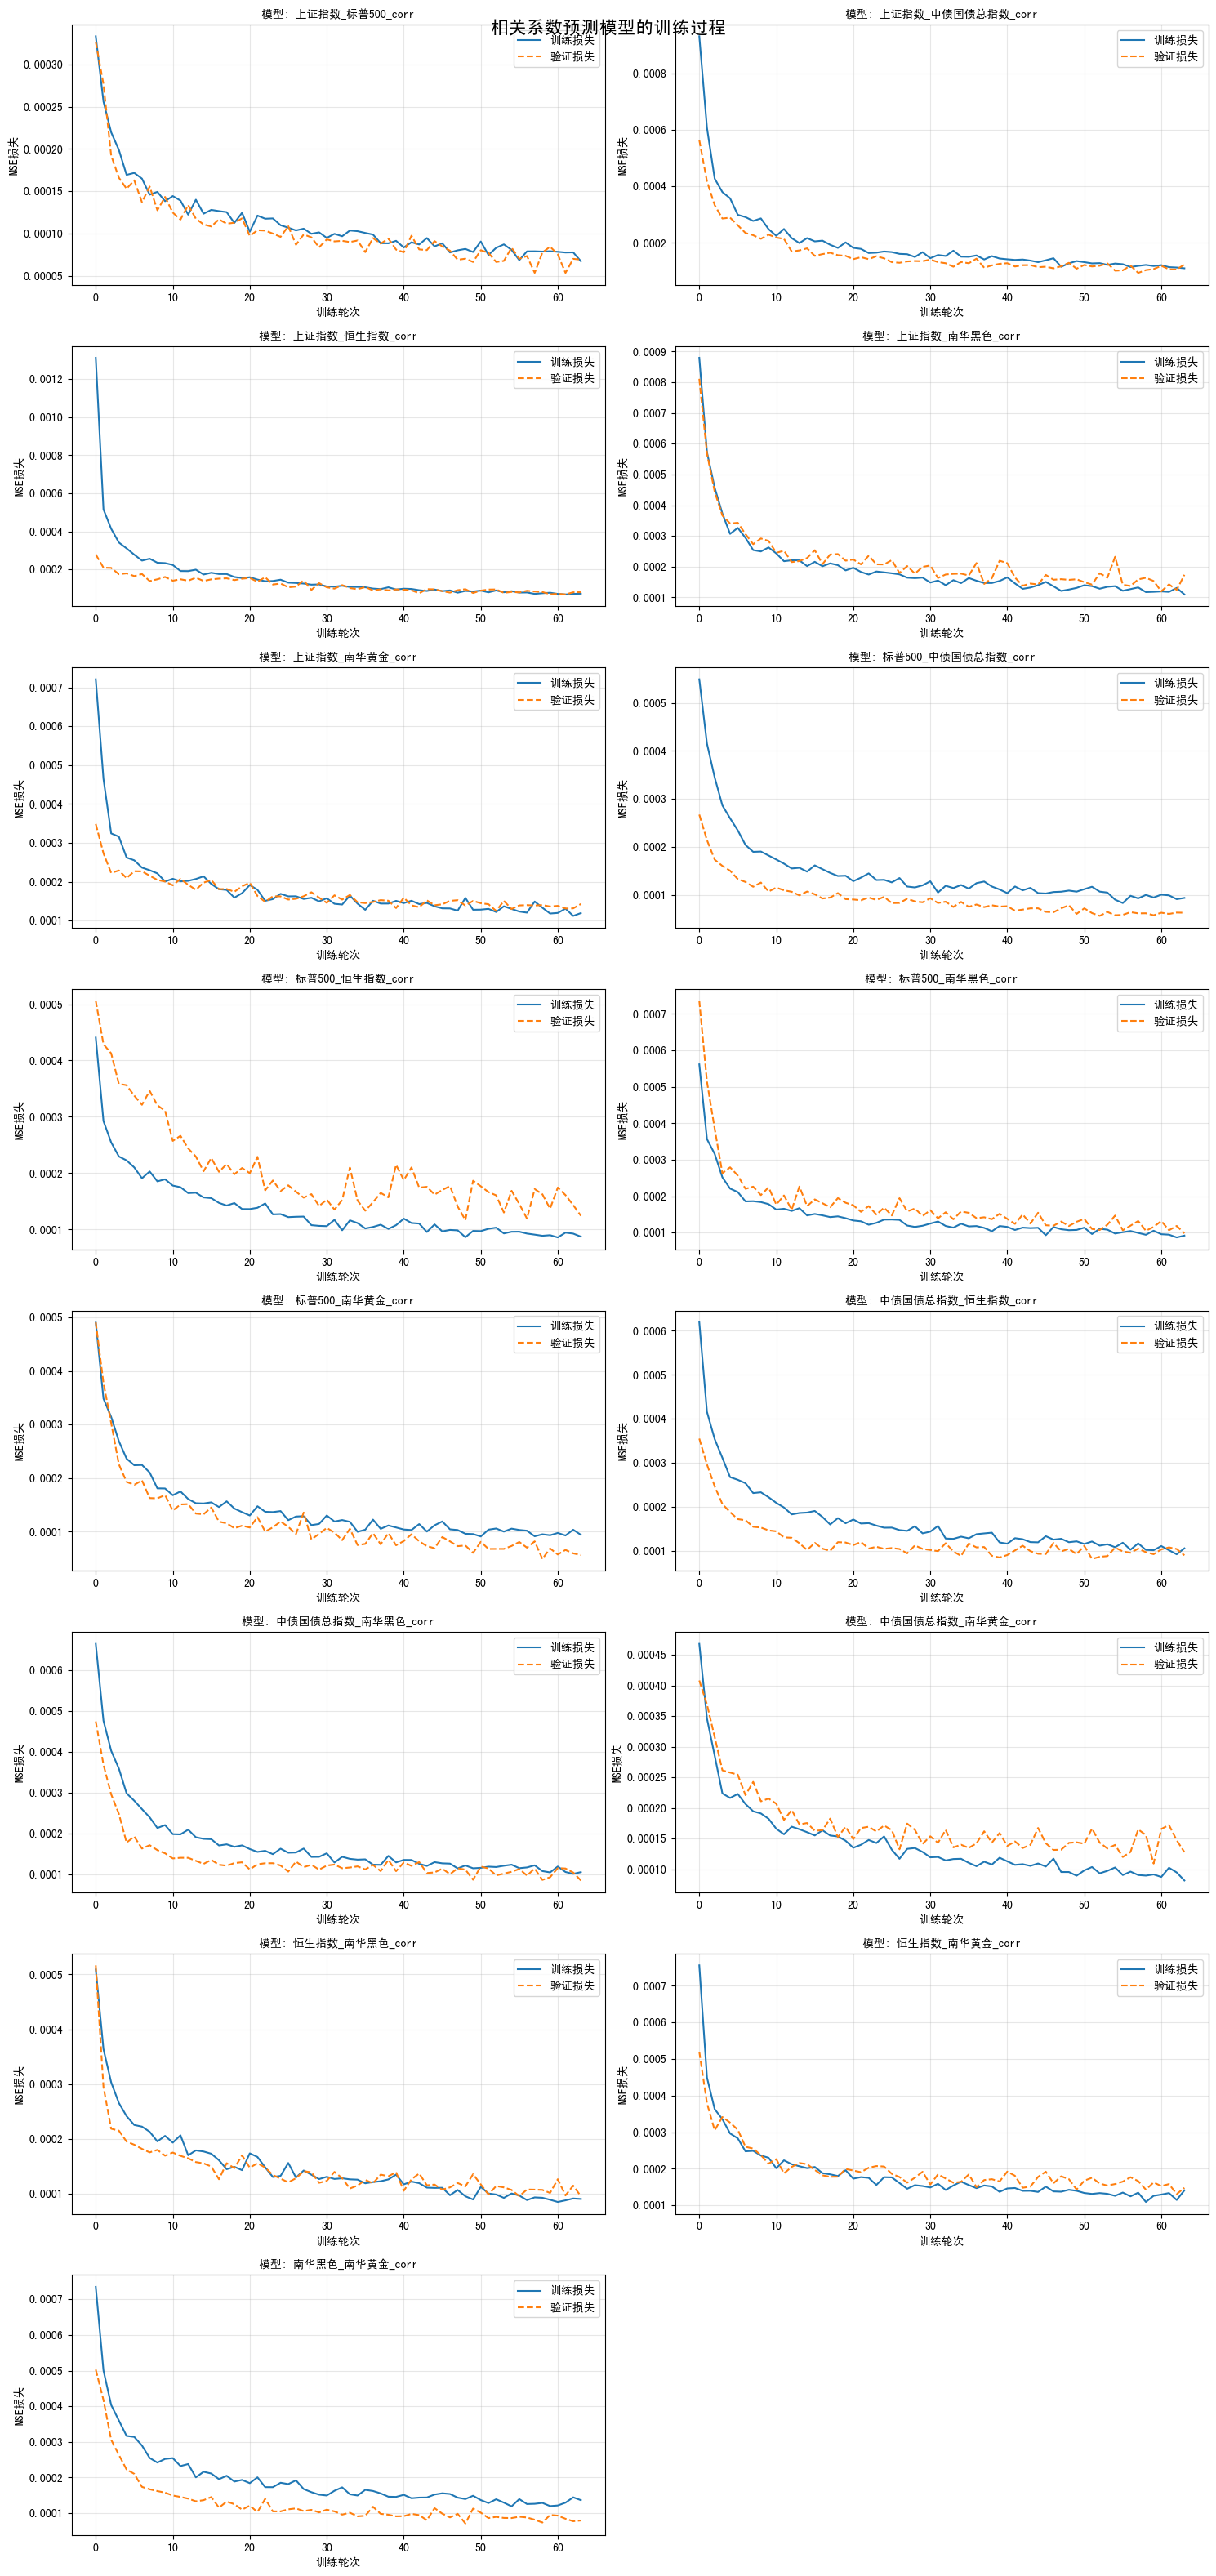

In [30]:
# 可视化相关系数模型的训练和验证损失
n_models = len(training_history)
n_rows = (n_models + 1) // 2  # 计算需要的行数
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(15, 4*n_rows))
fig.suptitle('相关系数预测模型的训练过程', fontsize=16, y=0.98)
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 遍历所有模型的训练过程
for idx, (column, history) in enumerate(training_history.items()):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    # 绘制训练/验证损失曲线
    ax.plot(history.history['loss'], label='训练损失')
    ax.plot(history.history['val_loss'], label='验证损失', linestyle='--')
    ax.set_title(f'模型: {column}', fontsize=10)
    ax.set_xlabel('训练轮次')
    ax.set_ylabel('MSE损失')
    ax.legend()
    ax.grid(True, alpha=0.3)

# 如果模型数量为奇数，删除最后一个空白子图
if n_models % 2 == 1:
    fig.delaxes(axes[n_rows-1, 1] if n_rows > 1 else axes[1])

plt.tight_layout()
plt.show()

In [31]:
# 评估收益率模型的预测结果
evaluation_metrics_corr = {}
for i, column in enumerate(rolling_corr.columns):
    y_test_column = y_test[:, i].reshape(-1, 1)
    predictions = training_history[column].model.predict(X_test)
    mae = mean_absolute_error(y_test_column, predictions)
    mse = mean_squared_error(y_test_column, predictions)
    r2 = r2_score(y_test_column, predictions)
    evaluation_metrics_corr[column] = {'平均绝对误差 (MAE)': mae, '均方误差 (MSE)': mse, '决定系数 (R²)': r2}
    
evaluation_metrics_returns_df = pd.DataFrame(evaluation_metrics_corr).T
evaluation_metrics_returns_df

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


,平均绝对误差 (MAE),均方误差 (MSE),决定系数 (R²)
上证指数_标普500_corr,0.006976,0.000081,0.846440
上证指数_中债国债总指数_corr,0.008488,0.000130,0.704459
上证指数_恒生指数_corr,0.014886,0.000395,0.334558
上证指数_南华黑色_corr,0.010059,0.000158,0.665065
上证指数_南华黄金_corr,0.009755,0.000155,0.835510
标普500_中债国债总指数_corr,0.006786,0.000074,0.832078
标普500_恒生指数_corr,0.009393,0.000131,0.749831
标普500_南华黑色_corr,0.006233,0.000059,0.859153
标普500_南华黄金_corr,0.004950,0.000040,0.873690
中债国债总指数_恒生指数_corr,0.008614,0.000111,0.821674


In [32]:
mae_hist_vs_true = {}
mae_model_vs_true = {}
mae_hist_avg_vs_true = {}
for i, column in enumerate(rolling_corr.columns[:17]):
    # 历史法预测值与真实值
    mae_hist = mean_absolute_error(y_test[:, i], y_hist[split_index:, i])
    # 模型预测值与真实值
    model_pred = training_history[column].model.predict(X_test).flatten()
    mae_model = mean_absolute_error(y_test[:, i], model_pred)
    mae_hist_vs_true[column] = mae_hist
    mae_model_vs_true[column] = mae_model

mae_compare_df = pd.DataFrame({
    '历史法MAE': mae_hist_vs_true,
    '模型预测MAE': mae_model_vs_true
})
mae_compare_df

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,历史法MAE,模型预测MAE
上证指数_标普500_corr,0.025191,0.006976
上证指数_中债国债总指数_corr,0.028032,0.008488
上证指数_恒生指数_corr,0.026761,0.014886
上证指数_南华黑色_corr,0.029347,0.010059
上证指数_南华黄金_corr,0.032645,0.009755
标普500_中债国债总指数_corr,0.022697,0.006786
标普500_恒生指数_corr,0.028374,0.009393
标普500_南华黑色_corr,0.023936,0.006233
标普500_南华黄金_corr,0.020829,0.004950
中债国债总指数_恒生指数_corr,0.028904,0.008614
